# Introduction 

This notebook performs preprocessing to prepare the data for clustering. 

# Imports

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer
from pca import pca
from sklearn.decomposition import PCA 
from sklearn.pipeline import make_pipeline
from src.visualize import univ_dist, plot_loadings

# Load Data

In [2]:
df_train = pd.read_csv('../data/interim/train.csv')
df_train.shape

(6146, 12)

In [3]:
# define the feature matrix 
X_train = df_train.drop(columns=['cik']) # CIK is a company identifier 

# Scaling and De-Skewing

EDA showed all of the features to be highly skewed, and some contain negative values. We will use the Yeo-Johnson transformation to handle that, centering each feature at 0 with a standard deviation of 1.

In [4]:
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [5]:
round(X_train_scaled.mean())

AssetsCurrent_USD                           -0.0
Assets_USD                                   0.0
CashAndCashEquivalentsAtCarryingValue_USD    0.0
CommonStockSharesAuthorized_shares          -0.0
CommonStockSharesIssued_shares               0.0
CommonStockValue_USD                         0.0
LiabilitiesAndStockholdersEquity_USD         0.0
LiabilitiesCurrent_USD                       0.0
Liabilities_USD                              0.0
RetainedEarningsAccumulatedDeficit_USD       0.0
StockholdersEquity_USD                       0.0
dtype: float64

In [6]:
round(X_train_scaled.std())

AssetsCurrent_USD                            1.0
Assets_USD                                   1.0
CashAndCashEquivalentsAtCarryingValue_USD    1.0
CommonStockSharesAuthorized_shares           1.0
CommonStockSharesIssued_shares               1.0
CommonStockValue_USD                         1.0
LiabilitiesAndStockholdersEquity_USD         1.0
LiabilitiesCurrent_USD                       1.0
Liabilities_USD                              1.0
RetainedEarningsAccumulatedDeficit_USD       1.0
StockholdersEquity_USD                       1.0
dtype: float64

Let's look at the univariate distributions post-transformation.

count    4.458000e+03
mean    -3.112011e-16
std      1.000112e+00
min     -2.399911e+00
25%     -7.106198e-01
50%      7.640218e-02
75%      6.748388e-01
max      3.581338e+00
Name: AssetsCurrent_USD, dtype: float64


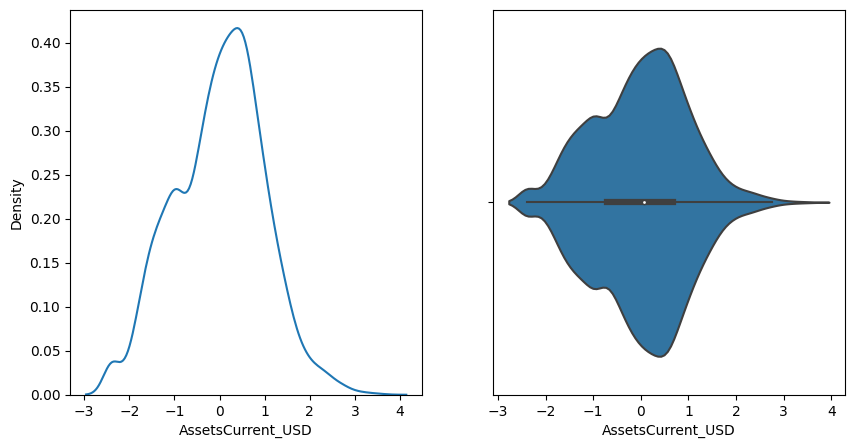

count    5.477000e+03
mean     1.031370e-16
std      1.000091e+00
min     -2.547569e+00
25%     -6.333924e-01
50%      3.660080e-02
75%      6.505819e-01
max      4.307338e+00
Name: Assets_USD, dtype: float64


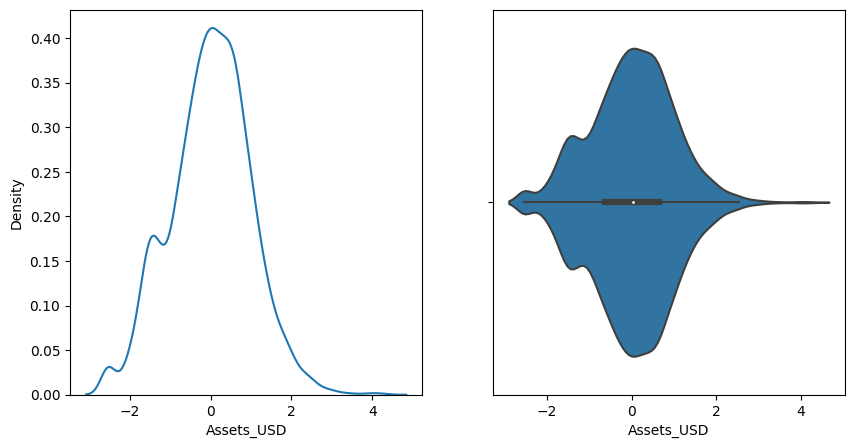

count    4.936000e+03
mean     4.750387e-17
std      1.000101e+00
min     -2.721880e+01
25%     -5.904236e-01
50%     -2.470798e-01
75%      2.549258e-01
max      1.413723e+01
Name: CashAndCashEquivalentsAtCarryingValue_USD, dtype: float64


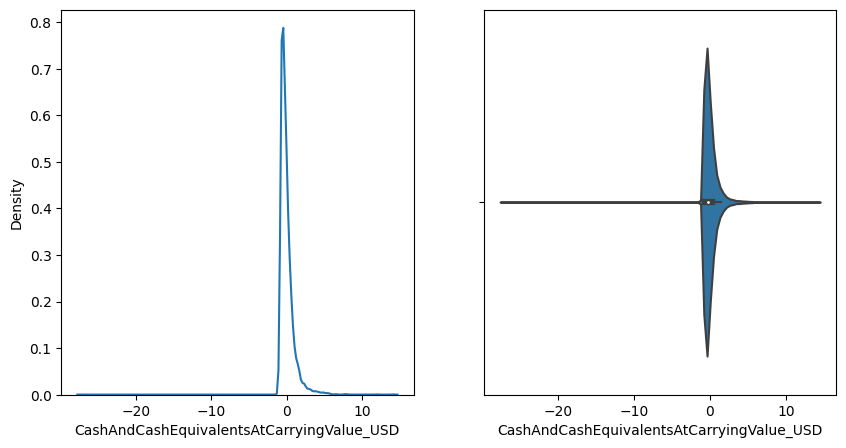

count    4.378000e+03
mean    -7.400811e-16
std      1.000114e+00
min     -4.939171e+00
25%     -5.345983e-01
50%     -7.452947e-03
75%      5.318980e-01
max      8.325453e+00
Name: CommonStockSharesAuthorized_shares, dtype: float64


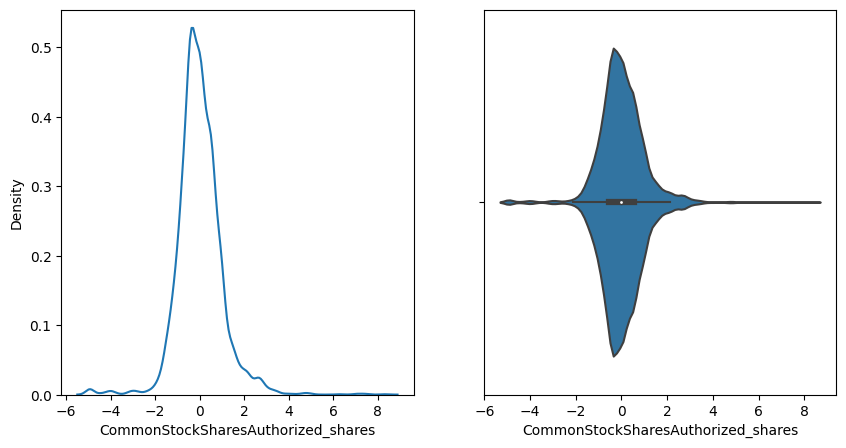

count    4.351000e+03
mean     2.335270e-16
std      1.000115e+00
min     -3.801263e+00
25%     -5.578263e-01
50%     -2.259060e-02
75%      5.017178e-01
max      9.486238e+00
Name: CommonStockSharesIssued_shares, dtype: float64


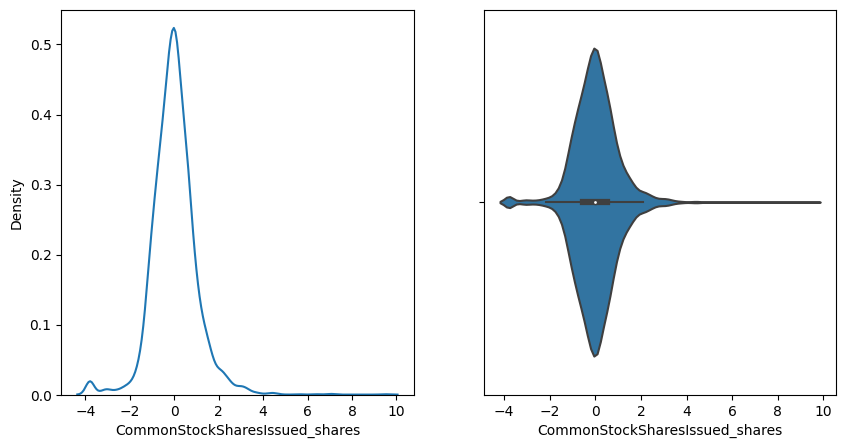

count    4.327000e+03
mean     1.514850e-16
std      1.000116e+00
min     -2.414795e+00
25%     -6.072881e-01
50%     -4.908083e-02
75%      5.549586e-01
max      3.377756e+00
Name: CommonStockValue_USD, dtype: float64


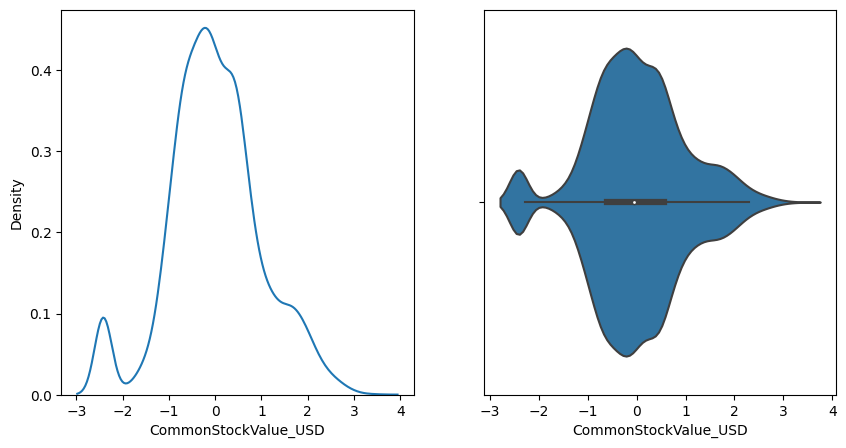

count    5.469000e+03
mean     4.319902e-17
std      1.000091e+00
min     -3.022320e+01
25%     -4.588847e-01
50%     -2.638461e-01
75%      1.206800e-01
max      1.650987e+01
Name: LiabilitiesAndStockholdersEquity_USD, dtype: float64


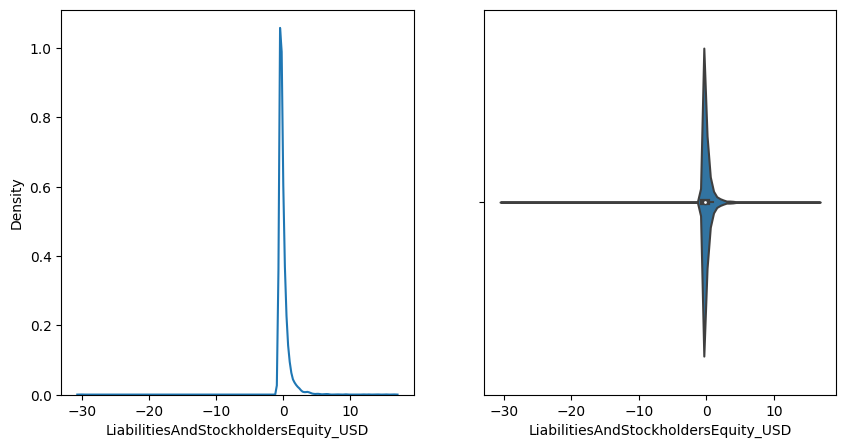

count    4.496000e+03
mean     4.662147e-17
std      1.000111e+00
min     -3.756999e+00
25%     -6.933636e-01
50%     -1.145025e-02
75%      7.066984e-01
max      3.182683e+00
Name: LiabilitiesCurrent_USD, dtype: float64


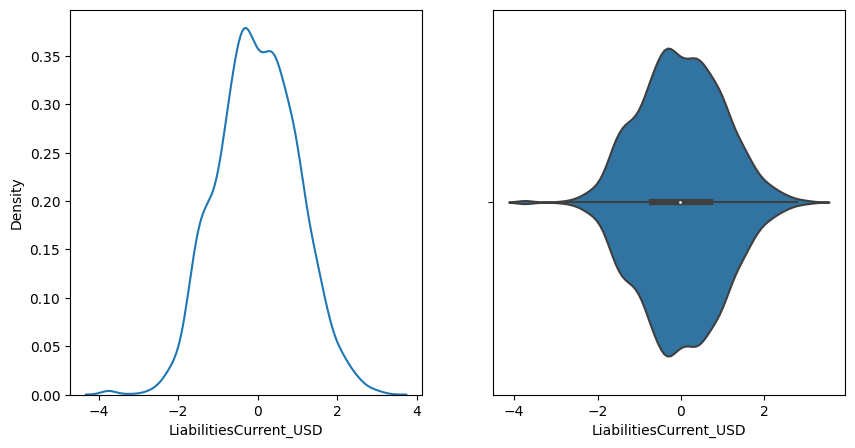

count    4.794000e+03
mean     2.075010e-17
std      1.000104e+00
min     -3.024052e+01
25%     -2.372423e-01
50%     -1.964872e-01
75%     -2.299734e-02
max      2.360578e+01
Name: Liabilities_USD, dtype: float64


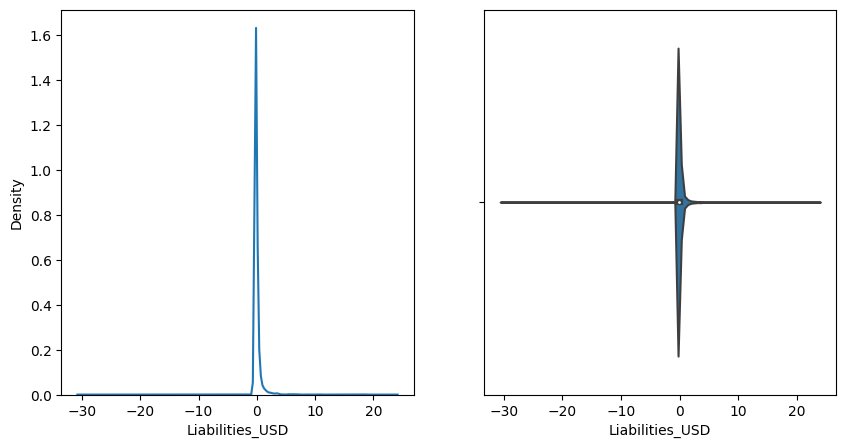

count    5.197000e+03
mean     2.734434e-18
std      1.000096e+00
min     -3.781168e+01
25%     -2.433004e-02
50%      9.990772e-03
75%      2.002694e-02
max      2.310793e+01
Name: RetainedEarningsAccumulatedDeficit_USD, dtype: float64


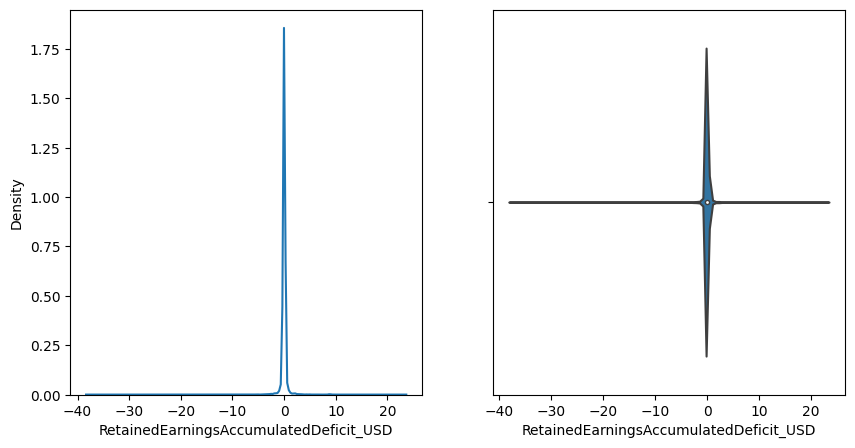

count    5.438000e+03
mean     1.829275e-17
std      1.000092e+00
min     -2.403155e+01
25%     -1.027202e-01
50%     -9.441567e-02
75%     -3.689661e-02
max      3.043840e+01
Name: StockholdersEquity_USD, dtype: float64


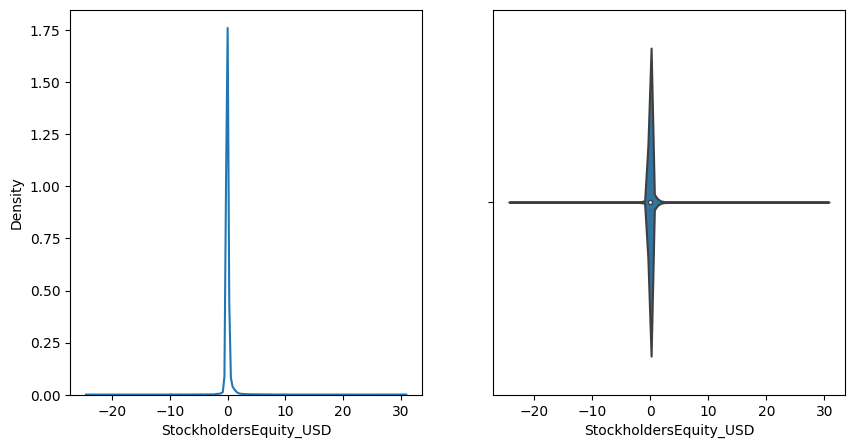

In [7]:
for c in X_train_scaled.columns:
    univ_dist(X_train_scaled[c], figsize=(10, 5))

# Imputation

Instead of naively imputing missing values with the mean or median, we can leverage the strong correlations among the features. The strong correlations mean that a data point's present features can provide useful information about its missing ones. We can therefore use a data point's nearest neighbors in the feature space to predict the value of it missing feature.

In [8]:
X_train_scaled.isna().sum() / len(X_train_scaled)

AssetsCurrent_USD                            0.274650
Assets_USD                                   0.108851
CashAndCashEquivalentsAtCarryingValue_USD    0.196876
CommonStockSharesAuthorized_shares           0.287667
CommonStockSharesIssued_shares               0.292060
CommonStockValue_USD                         0.295965
LiabilitiesAndStockholdersEquity_USD         0.110153
LiabilitiesCurrent_USD                       0.268467
Liabilities_USD                              0.219980
RetainedEarningsAccumulatedDeficit_USD       0.154409
StockholdersEquity_USD                       0.115197
dtype: float64

In [9]:
imputer = KNNImputer(weights='distance')
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=imputer.feature_names_in_)

In [10]:
X_train_imputed.isna().sum() / len(X_train_imputed)

AssetsCurrent_USD                            0.0
Assets_USD                                   0.0
CashAndCashEquivalentsAtCarryingValue_USD    0.0
CommonStockSharesAuthorized_shares           0.0
CommonStockSharesIssued_shares               0.0
CommonStockValue_USD                         0.0
LiabilitiesAndStockholdersEquity_USD         0.0
LiabilitiesCurrent_USD                       0.0
Liabilities_USD                              0.0
RetainedEarningsAccumulatedDeficit_USD       0.0
StockholdersEquity_USD                       0.0
dtype: float64

# Principal Component Analysis

Next we apply PCA to remove the multicollinearity among the features. 

In [11]:
pca_model = pca(n_components=0.9, random_state=1) # select the number of components that together explain 90% of the variance

In [12]:
pca_results = pca_model.fit_transform(X_train_imputed)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [11] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [11] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


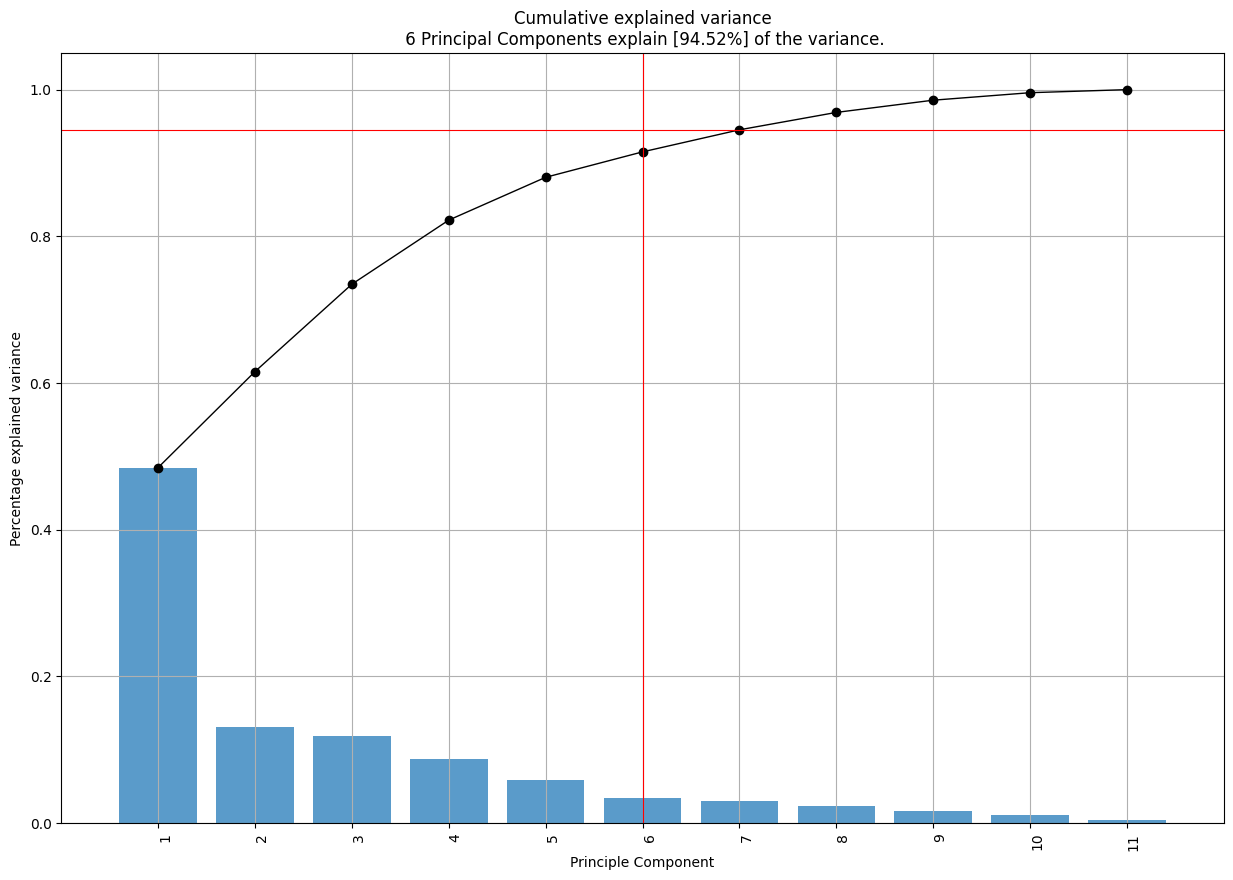

<Figure size 640x480 with 0 Axes>

In [13]:
pca_model.plot()
plt.show()

The first 6 principal components explain over 90% of the variance. Let's look at their loadings to facilitate interpretation.

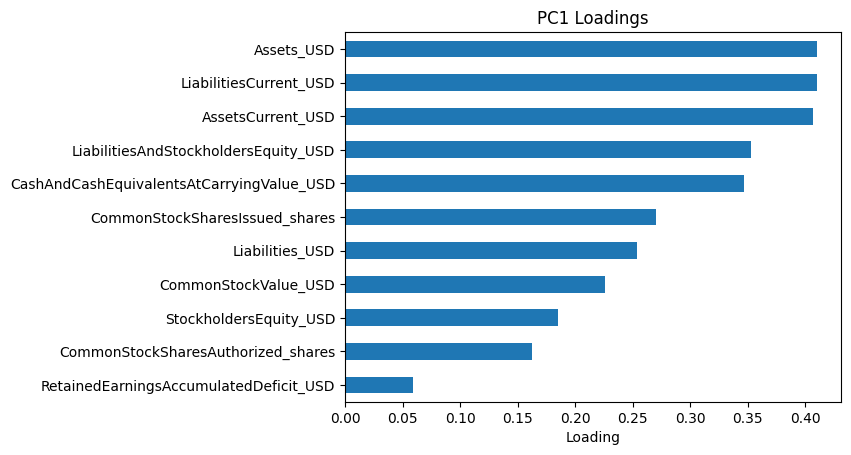

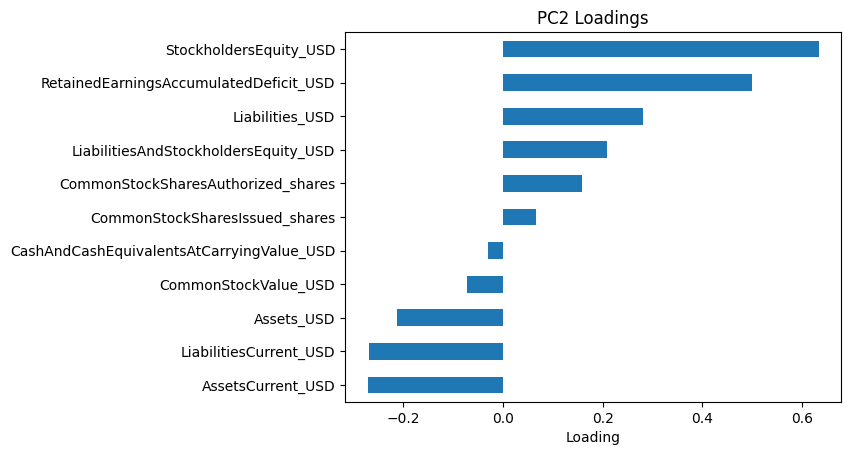

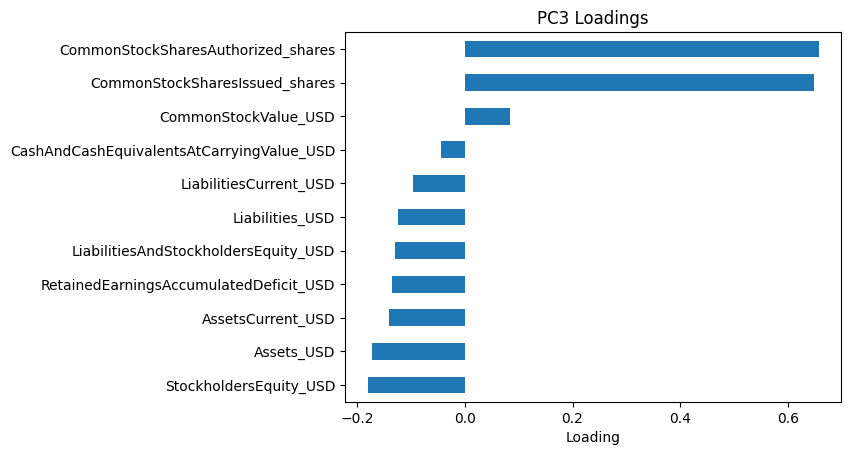

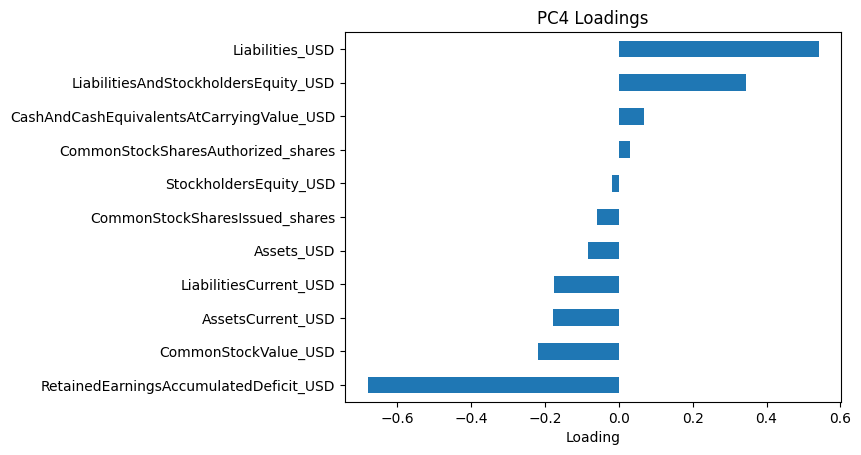

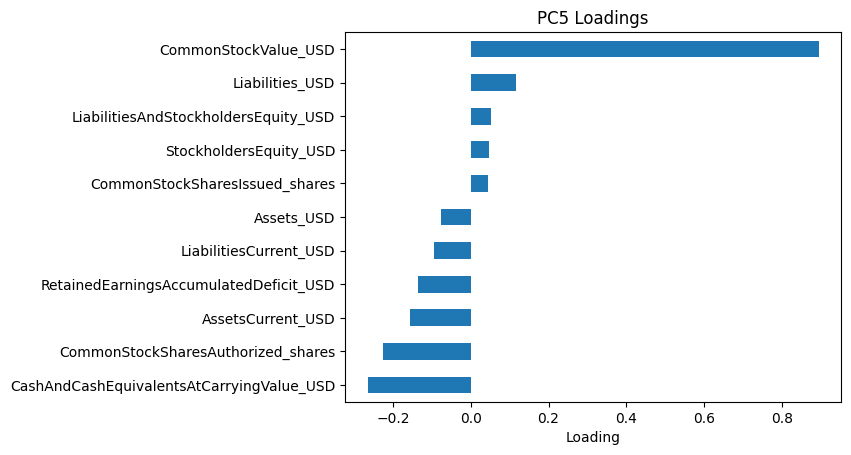

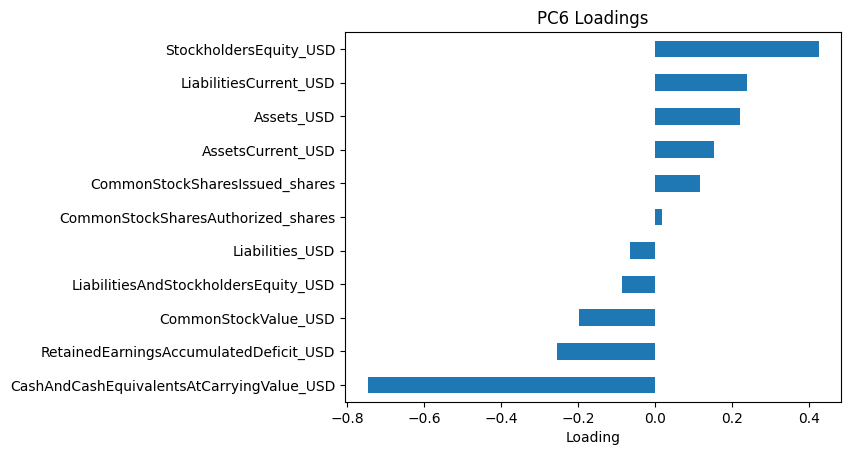

In [14]:
for c in pca_results['loadings'].index:
    plot_loadings(pca_results, c)

1. PC1 is positively correlated with every feature, so we can think of it as a measure of overall company size.
2. PC2 is most strongly correlated with StockholdersEquity_USD and appears to represent a company's overall value.
3. PC3 is strongly correlated with CommonStockSharesAuthorized_shares and CommonStockSharesIssued_shares so it seems to represent the supply of a company's common stock.
4. PC4 is moderately correlated with Liabilities_USD and strongly negatively correlated with RetainedEarningsAccumulatedDeficit_USD. Companies with more liabilities and a larger accumulated deficit are at greater risk of insolvency, all else being equal. So we can think of PC4 as a measure of insolvency risk.
5. PC5 appears to primarily just represent CommonStockValue_USD, as it is only slightly correlated with any other feature.
6. PC6 is strongly negatively correlated with CashAndCashEquivalentsAtCarryingValue_USD and moderately positively correlated with StockholdersEquity_USD, so it appears to represent the degree to which a company's assets are non-cash.

Let's plot the data projected onto the first two principal components. 

[pca] >Plot PC1 vs PC2 with loadings.


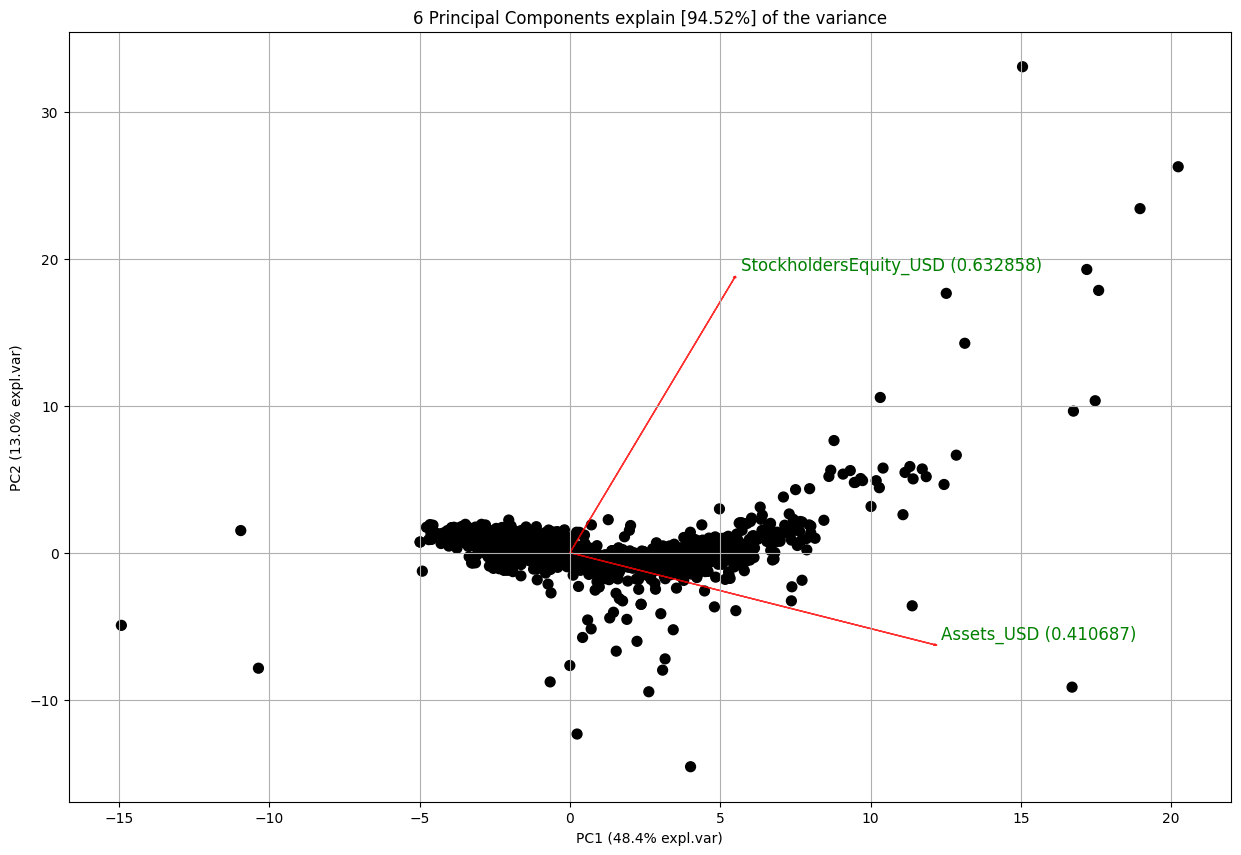

In [15]:
pca_model.biplot(
    y=np.ones(len(X_train)),
    n_feat=2,
    label=None,
    legend=False
)
plt.show()

Most companies cluster quite densely within the first two principal components. However, we can see some outliers in low-density regions. 

# Pipeline

Now let's put all of the transformations into a single pipeline so they can be applied to the test data without any leakage. 

In [16]:
pipeline = make_pipeline(
    PowerTransformer(method='yeo-johnson', standardize=True),
    KNNImputer(weights='distance'),
    PCA(n_components=6, random_state=1)
)

In [17]:
# load test data 
df_test = pd.read_csv('../data/interim/test.csv')
X_test = df_test.drop(columns=['cik'])
X_test.shape

(1537, 11)

In [18]:
# preprocess test data 
X_test_pca = pipeline.fit_transform(X_test)
X_test_pca.shape

(1537, 6)

In [19]:
# preprocess training data 
X_train_pca = pipeline.fit_transform(X_train) 
X_train_pca.shape

(6146, 6)

Write the preprocessed datasets to files. 

In [20]:
# write preprocessed training data to file 
df_train_pca = pd.DataFrame(
    X_train_pca,
    columns=pca_results['PC'].columns,
    index=df_train['cik']
)
df_train_pca.to_csv('../data/processed/train.csv')

In [21]:
# write preprocessed test data to file
df_test_pca = pd.DataFrame(
    X_test_pca,
    columns=pca_results['PC'].columns,
    index=df_test['cik']
)
df_test_pca.to_csv('../data/processed/test.csv')

Serialize the pipeline object so it can be easily loaded by other scripts. 

In [22]:
pickle.dump(pipeline, open('../models/pipeline.p', 'wb'))